## Data generation script
This notebook generates the training/ test dataset.

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from generate_TF import GenerateTF, FMAX, NP, get_freq


In [9]:
# Number of curves to generate. This will be the total number of training/ testing data.
# Number of samples per curve.
# points = 1 << 10

# Generate all combinations
a_lst = np.arange(-20, 20+0.5, 1)
b_lst = np.geomspace(0.001, 0.004, num=20, endpoint=True)
# a_lst = np.arange(-5, 5+0.5, 1)
# b_lst = np.geomspace(0.001, 0.004, num=10, endpoint=True)


# For each of these configs we can generate multiple datasets, since they are generated randomly
c_lst = [None] * 100 # this will generate 100 random instances per configuration

num_curves = len(a_lst) * len(b_lst) * len(c_lst)
print('Total number of datasets: ', num_curves)

Total number of datasets:  82000


In [16]:
gen_tf = GenerateTF(fb_attn_index=3, with_noise=True, noise_amplitude=0.1)
x = gen_tf.frequency
data = []
for c in c_lst:
    for a in a_lst:
        for b in b_lst:
            # Draw the random points, following the normal distribution
            # y = func(a, b, c, x)
            amplitudeDB, response = gen_tf(x, a, b, return_response=True)
            # add to the dataframe
            data.append({'phase': a, 'gain': b, 'fmax': FMAX, 'np': NP, 
                         'amplitude': amplitudeDB, 'real': response.real,
                          'imag': response.imag})
df = pd.DataFrame.from_records(data)
            # df = df.append({'phase': a, 'gain': b, 'freq': x,
            #                 'amplitude': amplitudeDB, 'real': response.real,
            #                 'imag': response.imag},
            #                ignore_index=True)


In [17]:
df.head()

,phase,gain,fmax,np,amplitude,real,imag
0,-20.0,0.001000,1.619443e+06,662,"[-23.357375491745664, -26.0851996017893, -33.5...","[-0.021054299508294433, 0.011429574087198234, ...","[-0.06459629148257023, -0.048295480826260104, ..."
1,-20.0,0.001076,1.619443e+06,662,"[-25.511325980758013, -24.718449487385854, -22...","[0.03595637676979386, 0.02166354899835697, 0.0...","[-0.038963847424329734, -0.05389590082010029, ..."
2,-20.0,0.001157,1.619443e+06,662,"[-28.81491896127936, -27.827786179958505, -22....","[0.029248474226871202, -0.0010979300410257227,...","[-0.021407072762403726, -0.040593069698999486,..."
3,-20.0,0.001245,1.619443e+06,662,"[-22.070854131154633, -30.845860065171713, -30...","[0.04974268693060286, 0.0186999550411898, 0.00...","[-0.061099382076756276, -0.02175634418295811, ..."
4,-20.0,0.001339,1.619443e+06,662,"[-20.804871672297395, -21.592750057670216, -21...","[-0.061915548957550866, -0.018752193856578357,...","[-0.06689377758231763, -0.08110624967159283, -..."


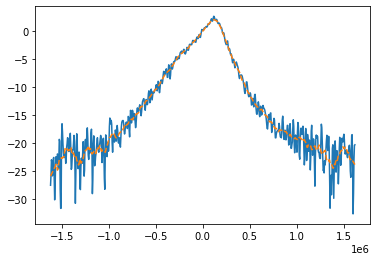

In [18]:
%matplotlib inline

from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

for index, row in df.sample(n=1).iterrows():
    y = row['amplitude']
    x = get_freq(row['fmax'], row['np'])
    savgol = savgol_filter(y, 17, 1)
    # label = f'm{m}-s{s}'
    p = plt.plot(x, y)
    plt.plot(x, savgol, ls='--')
plt.show()

In [18]:
from scipy.signal import savgol_filter
for index, row in df.iterrows():
    # y = row['y']
    name = f'gain{np.round(row["g_oo"], 4)}-phase{np.round(row["phi"], 2)}'
    x = row['x']
    real = row['real']
    imag = row['imag']
    y = np.abs(row['real'] + 1j*row['imag'])
    savgol_real = savgol_filter(real, 17, 1)
    savgol_imag = savgol_filter(imag, 17, 1)

    fig, axarr = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 4))
    plt.sca(axarr[0])
    plt.plot(x, real, color='black', alpha=0.5)
    plt.plot(x, savgol_real, color='blue')
    plt.title('real')
    plt.ylim(-1, 1.5)

    plt.sca(axarr[1])
    plt.plot(x, imag, color='black', alpha=0.5)
    plt.plot(x, savgol_imag, color='blue')
    plt.title('imag')
    plt.ylim(-1, 1.5)


    plt.sca(axarr[2])
    plt.plot(x, y, color='black', alpha=0.5)
    plt.plot(x, np.abs(savgol_real + 1j*savgol_imag), color='blue')
    plt.title('abs')
    plt.ylim(-1, 1.5)

    plt.tight_layout()

    # plt.plot(x, y)
    # plt.title(index)
    # plt.ylim(-50, 50)
    plt.savefig(f'plots/generated_curves/real_imag_nonoise/{name}.jpg', transparent=False)
    plt.close()

In [12]:
df.to_pickle(f'./data/tf-ampl-response-{num_curves}-noise0.1.pkl')